# Prevención de cancelación de contratos en compañías de telecomunicaciones

> <font size=4>*Daute Rodríguez Rodríguez*</font>

Este *notebook* presenta el proyecto final de la asignatura **Extracción de Conocimiento en Bases de Datos** del Máster Universitario en Ciberseguridad e Inteligencia de Datos de la Universidad de La Laguna.

El objetivo de este proyecto consiste en, a partir del estudio del fenómeno de pérdida de clientes, obtener un modelo de clasificación fiable capaz de anticipar si un cliente va a cancelar los servicios que tiene contratados. Esta clasificación o **predicción** se realizará atendiendo a las características propias del cliente y del contrato que el cliente mantiene con la compañía, para ello, se cuenta con un conjunto de [datos históricos etiquetados de una compañía de telecomunicaciones](https://www.kaggle.com/blastchar/telco-customer-churn) obtenido a través de la plataforma *Kaggle*.



> <font color="Coral">*En este notebook únicamente se presentan los fragmentos de código implementados para la realización del proyecto. La presentación del problema, el proceso llevado a cabo y los resultados obtenidos se exponen en el informe.*</font>



## Instalación de paquetes

En la siguiente celda de código se lleva a cabo la instalación de los paquetes necesarios:

In [ ]:
install.packages("caret")
install.packages("e1071")
install.packages("ROCR")
install.packages("rpart.plot")
install.packages("data.table")
install.packages("gtools")
install.packages("randomForest")

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘numDeriv’, ‘SQUAREM’, ‘lava’, ‘prodlim’, ‘iterators’, ‘data.table’, ‘gower’, ‘ipred’, ‘timeDate’, ‘foreach’, ‘ModelMetrics’, ‘recipes’, ‘pROC’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘bitops’, ‘gtools’, ‘gdata’, ‘caTools’, ‘gplots’


Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



## Carga de paquetes

La carga de los paquetes previamente instalados y de los que se hará uso a lo largo del *notebook* se lleva a cabo en la siguiente celda de código:

In [ ]:
library(tidyverse)
library(caret)
library(e1071)
library(ROCR)
library(data.table)
library(MASS)
library(rpart.plot)
library(gtools)
library(randomForest)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.2.1     ✔ purrr   0.3.3
✔ tibble  2.1.3     ✔ dplyr   0.8.3
✔ tidyr   1.0.0     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


Loading required package: gplots


Attaching package: ‘gplots’


The following object is masked from ‘package:stats’:

    lowess



Attaching package: ‘data.table’


The following objects are masked from ‘package:dplyr’:

    between, first, last


The following object is masked from ‘package:purrr’:

    transpose



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: rpart


Attaching package: ‘gtools’


The 

## Opciones del notebook

Conviene especificar que las gráficas presentes a lo largo del *notebook* se generen en formato svg por cuestiones de calidad de las imágenes.

In [ ]:
options(jupyter.plot_mimetypes = "image/svg+xml")

## Carga de datos

A continuación, se carga el conjunto de datos históricos y se muestran las primeras filas del *dataframe* para comprobar que la operación se ha llevado a cabo satisfactoriamente:

In [ ]:
path <- "data/TelcoCustomerChurnDataset.csv"
originalDF <- read.csv(file = path, header = TRUE)

df <- originalDF
head(df)

customerID gender SeniorCitizen Partner Dependents tenure PhoneService
1 7590-VHVEG Female 0             Yes     No          1     No          
2 5575-GNVDE Male   0             No      No         34     Yes         
3 3668-QPYBK Male   0             No      No          2     Yes         
4 7795-CFOCW Male   0             No      No         45     No          
5 9237-HQITU Female 0             No      No          2     Yes         
6 9305-CDSKC Female 0             No      No          8     Yes         
  MultipleLines    InternetService OnlineSecurity ⋯ DeviceProtection
1 No phone service DSL             No             ⋯ No              
2 No               DSL             Yes            ⋯ Yes             
3 No               DSL             Yes            ⋯ No              
4 No phone service DSL             Yes            ⋯ Yes             
5 No               Fiber optic     No             ⋯ No              
6 Yes              Fiber optic     No             ⋯ Yes             
  TechSupport StreamingTV StreamingMovies Contract       PaperlessBilling
1 No          No          No              Month-to-month Yes             
2 No          No          No              One year       No              
3 No          No          No              Month-to-month Yes             
4 Yes         No          No              One year       No              
5 No          No          No              Month-to-month Yes             
6 No          Yes         Yes             Month-to-month Yes             
  PaymentMethod             MonthlyCharges TotalCharges Churn
1 Electronic check          29.85            29.85      No   
2 Mailed check              56.95          1889.50      No   
3 Mailed check              53.85           108.15      Yes  
4 Bank transfer (automatic) 42.30          1840.75      No   
5 Electronic check          70.70           151.65      Yes  
6 Electronic check          99.65           820.50      Yes

## Descripción de los datos


En esta sección del *notebook* se presentan la naturaleza y características de los datos adquiridos para el análisis del fenómeno de pérdida de clientes. Como ya se ha mencionado con anterioridad, los datos de los que se dispone se corresponden con observaciones pertenecientes a una compañía de telecomunicaciones, cada observación incluye información y características de un cliente y del contrato que éste mantiene con la compañía. Concretamente, cada observación del conjunto de datos presenta los siguientes atributos:

* **<font color="green">customerID</font>**: Identificador único de cliente
* **<font color="green">gender</font>**: Género
* **<font color="green">SeniorCitizen</font>**: Indica si el cliente está jubilado
* **<font color="green">Partner</font>**: Indica si el cliente tiene pareja
* **<font color="green">Dependents</font>**: Indica si el cliente tiene personas a su cargo
* **<font color="green">tenure</font>**: Antiguedad del cliente en meses
* **<font color="green">PhoneService</font>**: Indica si el cliente tiene contratado servicio de teléfono
* **<font color="green">MultipleLines</font>**: Indica si el cliente tiene múltiples líneas de teléfono (depende del atributo PhoneService)
* **<font color="green">InternetService</font>**: Indica si el cliente tiene servicio de internet
* **<font color="green">OnlineSecurity</font>**: Indica si el cliente tiene el servicio de seguridad online (depende del atributo InternetService)
* **<font color="green">OnlineBackup</font>**: Indica si el cliente tiene el servicio de copias de seguridad (depende del atributo InternetService)
* **<font color="green">DeviceProtection</font>**: Indica si el cliente tiene protección de dispositivos (depende del atributo InternetService)
* **<font color="green">TechSupport</font>**: Indica si el cliente tiene el servicio de soporte técnico (depende del atributo InternetService)
* **<font color="green">StreamingTV</font>**: Indica si el cliente tiene el servicio StreamingTV
* **<font color="green">StreamingMovies</font>**: Indica si el cliente tiene el servicio StreamingMovies
* **<font color="green">Contract</font>**: La duración del contrato (mes a mes, un año o dos años)
* **<font color="green">PaperlessBilling</font>**: Indica si el cliente tiene facturación electrónica
* **<font color="green">PaymentMethod</font>**: Método de pago
* **<font color="green">MonthlyCharges</font>**: Cuantía mensual
* **<font color="green">TotalCharges</font>**: Cuantía total pagada
* **<font color="green">Churn</font>**: Si el cliente abandonó o no.

Ejecutando la siguiente celda de código es posible ver la dimensionalidad del *dataframe*. El conjunto de datos está conformado por 7043 observaciones y 21 atributos. También se puede observar el tipo de datos de cada atributo:

In [ ]:
glimpse(df)

Observations: 7,043
Variables: 21
$ customerID       <fct> 7590-VHVEG, 5575-GNVDE, 3668-QPYBK, 7795-CFOCW, 9237…
$ gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fema…
$ SeniorCitizen    <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Y…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, N…
$ tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, …
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes, …
$ MultipleLines    <fct> No phone service, No, No, No phone service, No, Yes,…
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber …
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No…
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No i…
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No i…
$ TechSupport     

A continuación se presentan los posibles niveles de cada variable categórica y algunos valores estadísticos de las variables numéricas:

In [ ]:
summary(df)

      customerID      gender     SeniorCitizen    Partner    Dependents
 0002-ORFBO:   1   Female:3488   Min.   :0.0000   No :3641   No :4933  
 0003-MKNFE:   1   Male  :3555   1st Qu.:0.0000   Yes:3402   Yes:2110  
 0004-TLHLJ:   1                 Median :0.0000                        
 0011-IGKFF:   1                 Mean   :0.1621                        
 0013-EXCHZ:   1                 3rd Qu.:0.0000                        
 0013-MHZWF:   1                 Max.   :1.0000                        
 (Other)   :7037                                                       
     tenure      PhoneService          MultipleLines     InternetService
 Min.   : 0.00   No : 682     No              :3390   DSL        :2421  
 1st Qu.: 9.00   Yes:6361     No phone service: 682   Fiber optic:3096  
 Median :29.00                Yes             :2971   No         :1526  
 Mean   :32.37                                                          
 3rd Qu.:55.00                                             

## Preprocesamiento de los datos

Antes de estudiar los datos y aplicar sobre ellos las técnicas de visualización y los algoritmos de construcción de modelos es necesario llevar a cabo una serie de tareas de limpieza, transformación y adecuación. Cabe destacar que algunas de las transformaciones que a continuación se exponen se realizan únicamente con el propósito de obtener mejores resultados a la hora de visualizar los datos. También es importante mencionar que a pesar de aplicar las transformaciones pertinentes, en ningún momento se pierden o sobrescriben los datos originales (se han copiado previamente). 

#### Cambio de nombre de columnas

Todos los nombres de las columnas empiezan por mayúscula exceptuando __gender__, __tenure__ y __customerID__:

In [ ]:
df = df %>% rename(Gender = gender, CustomerID = customerID, Tenure = tenure)

#### Tratamiento de valores nulos

La columna __TotalCharges__ alberga 11 valores nulos. Al ser un numero reducido, conviene imputar dichos valores con la mediana de la columna:

In [ ]:
totalChargesMedian <- median(df$TotalCharges[which(!is.na(df$TotalCharges))])
df$TotalCharges <- df$TotalCharges %>% replace_na(totalChargesMedian)

#### Conversión de tipos de datos


El atributo **CustomerID** debería ser de tipo _character_ en vez de _factor_, pues representa un identificador de cliente:

In [ ]:
df$CustomerID <- as.character(df$CustomerID)

El atributo **SeniorCitizen** puede ser representado como factor, al igual que el resto de atributos categoricos:


In [ ]:
df$SeniorCitizen <- as.factor(df$SeniorCitizen)

#### Cambio de valores de variables categóricas

Los valores del atributo __SeniorCitizen__ deberían estar en consonancia con el resto de valores de los atributos categóricos del _dataframe_:

In [ ]:
df$SeniorCitizen <- recode(df$SeniorCitizen, `1` = "Yes", `0` = "No")

Con el propósito de hacer más legibles las figuras que se generarán más adelante, es conveniente cambiar los niveles de los atributos **Churn**, **PaymentMethod** y **Contract**:

In [ ]:
df$Churn <- recode(df$Churn, `Yes` = "Churn", `No` = "Not churn")
df$PaymentMethod <- recode(df$PaymentMethod, `Bank transfer (automatic)` = "Bank Transfer(A)", `Credit card (automatic)` = "Credit card(A)")
df$Contract <- recode(df$Contract, `Month-to-month` = "Monthly")

A continuación se eliminarán ciertos niveles redundantes de algunas variables categóricas de cara al proceso de construcción de modelos:

In [ ]:
simplifiedDf <- df[,c("MultipleLines", "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies")]

simplifiedDf <- data.frame(lapply(simplifiedDf, function(element) {
                  gsub("No internet service", "No", element)}))

simplifiedDf <- data.frame(lapply(simplifiedDf, function(element) {
                  gsub("No phone service", "No", element)}))

#### Categorización de atributos

Conviene categorizar algunos atributos para poder hacer uso de los mismos a la hora de utilizar algoritmos de construcción de modelos que únicamente admitan atributos categóricos y con el propósito de poder estudiarlos e interpretarlos de manera más simple.

##### **Tenure**

In [ ]:
max(df$Tenure)
min(df$Tenure)

[1] 72

[1] 0

In [ ]:
df <- mutate(df, CatTenure = cut(
  Tenure,
  include.lowest = TRUE,
  breaks = c(0, 12, 24, 36, 48, 60, 72),
  labels = c("0-1 year", "1-2 years", "2-3 years", "3-4 years", "4-5 years", "5-6 years")
))

##### **MonthlyCharges**

In [ ]:
max(df$MonthlyCharges)
min(df$MonthlyCharges)

[1] 118.75

[1] 18.25

In [ ]:
df <- mutate(df, CatMonthlyCharges = cut(
  MonthlyCharges, 
  include.lowest = TRUE, 
  breaks = c(18.25, 51.75, 85.25, 118.75), 
  labels = c("Low", "Middle", "High")))

##### **TotalCharges**

In [ ]:
max(df$TotalCharges)
min(df$TotalCharges)

[1] 8684.8

[1] 18.8

In [ ]:
df <- mutate(df, CatTotalCharges = cut(
  TotalCharges, 
  include.lowest = TRUE, 
  breaks = c(18.8, 2907.46, 5796.12, 8684.8), 
  labels = c("Low", "Middle", "High")))

#### Normalización de atributos numéricos

Con el propósito de evitar que los atributos numéricos con una escala mayor predominen sobre los atributos con escalas menores a la hora de aplicar los algoritmos de obtención de modelos se llevó a cabo la normalización de los mismos aplicando la estrategia *z-score*.

In [ ]:
normalizedFeatures <- df[,c("Tenure", "MonthlyCharges", "TotalCharges")]
normalizedFeatures <- data.frame(scale(normalizedFeatures))

#### Creación de atributos *dummy*

Algunos modelos como los de regresión logística no admiten variables categóricas no binarias, o lo que es lo mismo, requieren que las variables categóricas de más de dos clases se codifiquen como variables binarias. Los atributos *dummy* son variables que únicamente pueden tomar los valores 0 o 1 e indican la ausencia o presencia de un efecto categórico.

In [ ]:
dummiesDf <- df %>% select_if(is.factor)

for (attributeName in simplifiedDf %>% names) {
  dummiesDf[[attributeName]] <- simplifiedDf[[attributeName]]
}

dummiesDf$InternetService <- relevel(df$InternetService, ref = "No")

dummiesDf <- data.frame(sapply(dummiesDf, function(x) data.frame(model.matrix( ~x-1, data = dummiesDf))[,-1]))
# dummiesDf$Churn <- relevel(df$Churn, ref = "Churn")
dummiesDf$Churn <- df$Churn

glimpse(dummiesDf)

Observations: 7,043
Variables: 30
$ Gender                          <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1…
$ SeniorCitizen                   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner                         <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1…
$ Dependents                      <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0…
$ PhoneService                    <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1…
$ MultipleLines                   <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1…
$ InternetService.xDSL            <dbl> 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0…
$ InternetService.xFiber.optic    <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1…
$ OnlineSecurity                  <dbl> 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0…
$ OnlineBackup                    <dbl> 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0…
$ DeviceProtection                <dbl> 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1…
$ TechSupport                     <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ StreamingTV     

## Análisis exploratorio

A lo largo de esta sección se generan las figuras que se exponen en el informe del proyecto. Cabe destacar que la totalidad de gráficas no están presentes en el informe. Por comodidad, se almacenan por el nombre del atributo en *environments* de manera que son accesibles en cualquier momento.

#### Atributos categóricos

Las primeras gráficas a generar son las de los atributos categóricos:

* Gráficas de barras
* Gráficas de barras agrupando los atributos por el valor del atributo **Churn**
* Gráficas tipo donut

##### Gráficas de barras

En estas gráficas es posible observar la distribución de valores de cada atributo.

In [ ]:
barsPlots <- new.env()

for (attributeName in df %>% select_if(is.factor) %>% names) {
  # Save the plot in the barsPlots environment
  barsPlots[[attributeName]] <- ggplot(data = df, aes_string(x=attributeName, fill = attributeName)) +
    geom_bar() +
    theme(text = element_text(size = 14)) +
    geom_text(stat = "count", aes(label = ..count..), vjust = -.2, size = 5) +
    labs(y = "Cantidad")
}

##### Gráficas de barras frente a **Churn**

Estas gráficas se generan con el propósito de estudiar la distribución de los valores de los atributos teniendo en cuenta el valor del atributo a predecir, es decir, para los clientes que abandonan y los que permanecen.

In [ ]:
barsPlotsWithChurn <- new.env()

for (attributeName in df %>% select_if(is.factor) %>% names) {
  # Save the plot in the barsPlotsWithChurn environment
  barsPlotsWithChurn[[attributeName]] <- ggplot(df, aes_string(x = attributeName, group = "Churn")) +
    geom_bar(aes(y = ..prop.., fill = factor(..x..)), stat = "count") +
    geom_text(aes( label = scales::percent(round(..prop.., 3)), y = ..prop..), stat = "count", vjust = -.2, size = 5) +
    labs(y = "Percent", fill = attributeName) +
    facet_grid(~Churn) +
    scale_y_continuous(labels = scales::percent) +
    theme(text = element_text(size = 14)) +
    labs(y = "Porcentaje")
}

##### Gráficas de tipo "donut"

Al igual que con las gráficas de barras, este tipo de visualización muestra la distribución de valores de los atributos. Sin embargo, mientras que en las gráficas de barras es posible ver la cantidad exacta de ocurrencias de cada nivel de la variable categórica, en las gráficas de tipo donut se presenta la distribución de valores por medio de porcentajes.

In [ ]:
donutPlots <- new.env()

for (attributeName in df %>% select_if(is.factor) %>% names) {
  # Prepare data
  data <- as.data.frame(table(df[attributeName], dnn = "class"))

  # Compute percentage
  data$percentage <- data$Freq / sum(data$Freq)

  # Compute the cummulative percentages
  data$ymax <- cumsum(data$percentage)
  data$ymin <- c(0, head(data$ymax, n = -1))

  # Compute label position
  data$labelPosition <- (data$ymax + data$ymin) / 2

  # Set label text
  data$label <- paste0(formatC(100 * data$percentage, format = "g", digits = 2), "%")

  # Save the plot in the donutPlots environment
  donutPlots[[attributeName]] <- ggplot(data, aes(ymax = ymax, ymin = ymin, xmax = 4, xmin = 3, fill = class)) +
    geom_rect() +
    labs(fill = attributeName) +
    geom_text(x = 2, aes(y = labelPosition, label = label, color = class), size = 9, show.legend = FALSE) +
    coord_polar(theta="y", start=0) +
    xlim(c(-1, 4)) +
    theme_void() +
    theme(text = element_text(size = 14))
}

#### Atributos numéricos

Para los atributos numéricos se generarán los siguientes tipos de gráficas:

* Gráficas de densidad
* Gráficas de densidad atendiendo al valor del atributo **Churn**
* Gráficas tipo boxplot
* Gráficas tipo violín

##### Gráficas de densidad

Muestran la distribución de valores de los atributos continuos.

In [ ]:
densityPlots <- new.env()

for (attributeName in df %>% select_if(is.numeric) %>% names) {
  densityPlots[[attributeName]] <- ggplot(df,aes_string(x = attributeName)) +
    geom_density(alpha = 0.4, fill = "lightblue") +
    theme(text = element_text(size = 14)) +
    ylab("Densidad")
}

##### Gráficas de densidad frente al atributo **Churn**

Visualizan la distribución de valores de los atributos continuos para cada posible valor del atributo **Churn**, es decir, para los clientes que abandonan y los que permanecen.

In [ ]:
densityPlotsWithChurn <- new.env()

for (attributeName in df %>% select_if(is.numeric) %>% names) {
  densityPlotsWithChurn[[attributeName]] <- ggplot(df, aes_string(x = attributeName, fill = "Churn")) +
    geom_density(alpha = 0.4) +
    theme(text = element_text(size = 14)) +
    ylab("Densidad")
}

##### Boxplots

Presentan de forma gráfica algunos estadísticos como: la mediana, el primer y tercer cuartil, el valor mínimo, el valor máximo y los outliers. Cabe destacar que se presenta un Boxplot por cada valor del atributo **Churn**, es decir, para los clientes que abandonan y los que permanecen.

In [ ]:
boxPlots <- new.env()

for (attributeName in df %>% select_if(is.numeric) %>% names) {
  boxPlots[[attributeName]] <- ggplot(df, aes_string(x = "Churn", y = attributeName, fill = "Churn")) +
    geom_boxplot() +
    theme(text = element_text(size = 14))
}

##### Violinplots

Pueden verse como una combinación de las gráficas de tipo Boxplot y las gráficas de densidad, al igual que con los Boxplots, se presenta un Violinplot por cada valor del atributo **Churn**, es decir, para los clientes que abandonan y los que permanecen.

In [ ]:
violinPlots <- new.env()

for (attributeName in df %>% select_if(is.numeric) %>% names) {
  violinPlots[[attributeName]] <- df %>% ggplot(aes_string(x = "Churn", fill = "Churn", y = attributeName)) + 
    geom_violin(trim = FALSE, draw_quantiles = c(0.25, 0.5, 0.75)) +
    theme(text = element_text(size = 14))
}

#### Visualización

Para visualizar las gráficas generadas se deberá acceder a las propiedades de los *environments* que las almacenan. Por ejemplo, para visualizar las siguientes gráficas:
- Gráfica de barras del atributo **PaymentMethod**
- Gráfica tipo "donut" del atributo **MultipleLines**
- Gráfica de barras del atributo **SeniorCitizen** frente al atributo **Churn**
- Gráfica de densidad del atributo **MonthlyCharges**
- Gráfica de densidad del atributo **MonthlyCharges** frente al atributo **Churn**
- Gráfica tipo boxplot del atributo **Tenure**
- Gráfica tipo violín del atributo **TotalCharges**

Se habrá de ejecutar un código similar al de las siguientes celdas:

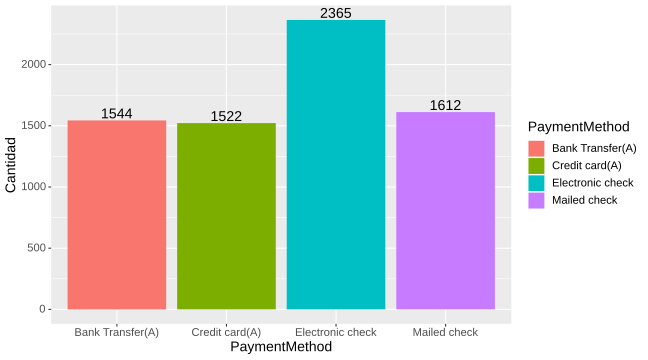

In [ ]:
options(repr.plot.width  = 9, repr.plot.height = 5)
barsPlots$PaymentMethod

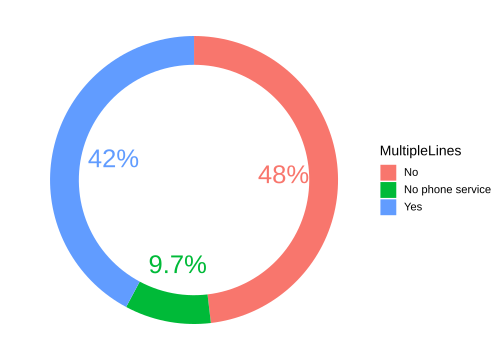

In [ ]:
options(repr.plot.width  = 7, repr.plot.height = 5)
donutPlots$MultipleLines

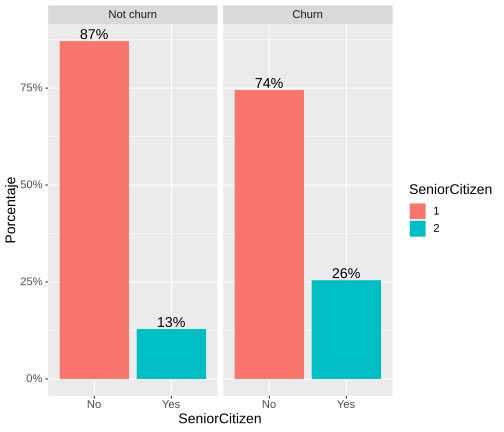

In [ ]:
options(repr.plot.width  = 7, repr.plot.height = 6)
barsPlotsWithChurn$SeniorCitizen

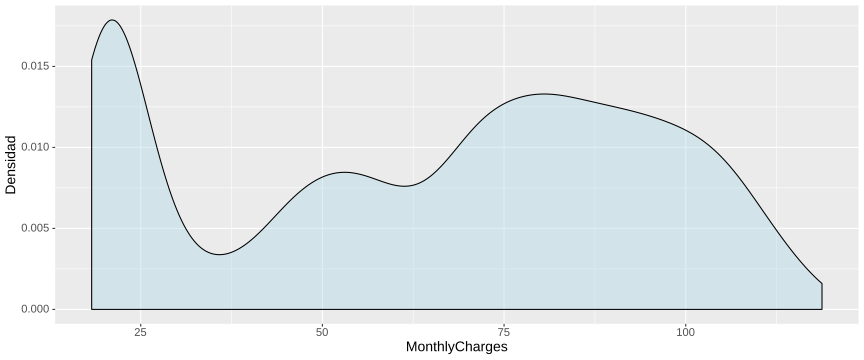

In [ ]:
options(repr.plot.width  = 12, repr.plot.height = 5)
densityPlots$MonthlyCharges

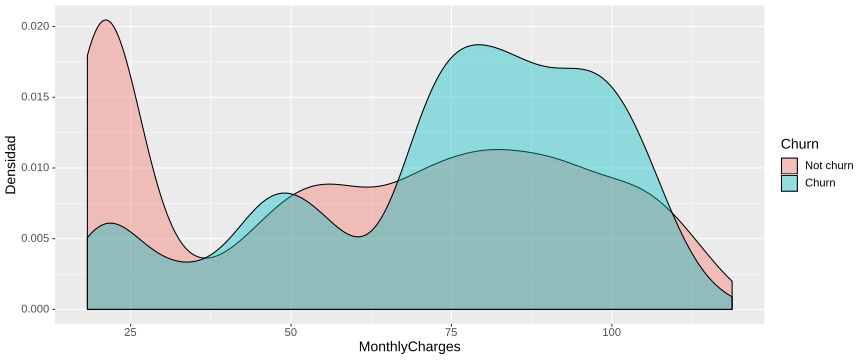

In [ ]:
options(repr.plot.width  = 12, repr.plot.height = 5)
densityPlotsWithChurn$MonthlyCharges

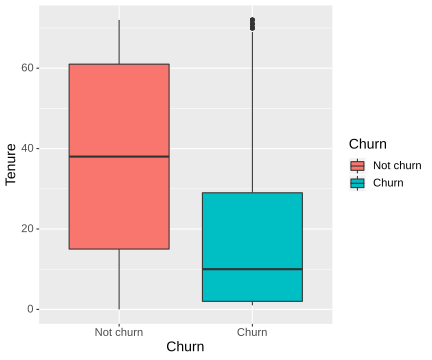

In [ ]:
options(repr.plot.width  = 6, repr.plot.height = 5)
boxPlots$Tenure

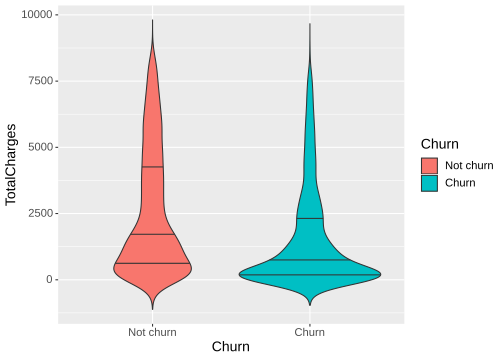

In [ ]:
options(repr.plot.width  = 7, repr.plot.height = 5)
violinPlots$TotalCharges

## Construcción de modelos de clasificación

En la variable _results_ que se crea a continuación se almacenarán los modelos obtenidos, las distintas métricas de rendimiento y los dataframes utilizados.

In [ ]:
results <- list(models = new.env(), metrics = new.env(), dataframes = new.env(), predictions = new.env())

Establecimiento del coste asociado a cada error de clasificación:

In [ ]:
FNCost <- 3
FPCost <- 1

### Funciones auxiliares

In [ ]:
# Returns cost associated to a prediction
#
# @params conf Confusion matrix
# @params FNCost Cost of each FN
# @params FPCost Cost of each FP
# @return Total cost
getTotalCost <- function(conf, FNCost, FPCost) {
  confAsTable <- as.table(conf)
  totalCost <- confAsTable[2] * FNCost + confAsTable[3] * FPCost
  return (totalCost)
}

In [ ]:
# Returns several statistics given a confusion matrix
#
# @params conf Confusion matrix
# @return Statistics
getStatistics <- function(conf) {
  return (list(
    accuracy = conf$overall[[1]], 
    kappa = conf$overall[[2]], 
    TPRate = conf$byClass[[1]], 
    TNRate = conf$byClass[[2]], 
    precision = conf$byClass[[5]], 
    f1 = conf$byClass[[7]]
  ))

}

In [ ]:
# Returns ROC plot given a confusion matrix
# 
# @params conf Confusion matrix
# @return ROC plot
plotROC <- function(conf) {
  xValue <- (1 - as.numeric(conf$byClass[2]))
  yValue <- as.numeric(conf$byClass[1])

  points <- data.frame(
    x = c(0, xValue, 1),
    y = c(0, yValue,1)
  )

  auc <- ((1 - xValue) * yValue) + 
    (((1 - xValue) * (1 - yValue)) / 2) + 
    ((yValue * xValue) / 2)

  label <- paste("AUC: ", round(auc, 4))

  return (list(
    plot = ggplot(points, aes(x = x)) +
      geom_area(aes(y = y), alpha = 0.3, fill = "lightblue", color = "steelblue") +
      scale_x_continuous(name = "Tasa de falsos positivos", breaks = seq(0, 1, length = 11)) +
      scale_y_continuous(name = "Tasa de verdaderos positivos", breaks = seq(0, 1, length = 11)) +
      geom_text(x = 0.5, y = 0.5, label = label, color = "steelblue") +
      theme(text = element_text(size = 14)),
    auc = auc
  ))
}

### Regresión logística

Se establece la semilla para la generación de números psudoaleatorios y se dividen las observaciones del conjunto de datos en dos grupos:

* Entrenamiento: 70% de las observaciones
* Validación: 30% restante de las observaciones

Los atributos que conforman el *dataframe* para la construcción de modelos de regresión logística son los siguientes:

* Atributos numéricos normalizados
* Atributos categóricos de dos niveles y atributos dummy de los atributos categóricos con más de dos niveles
* Los atributos dummy de los atributos numéricos categorizados CatTenure y CatMonthlyCharges no son necesarios pues la regresión logística permite variables numéricas y en el dataframe ya se encuentran las variables MonthlyCharges y Tenure normalizadas

In [ ]:
logisticRegressionDf <- cbind(dummiesDf[,-(22:30)], normalizedFeatures)
glimpse(logisticRegressionDf)
results$dataframes$lr <- logisticRegressionDf

set.seed(23)

trainPartition <- createDataPartition(logisticRegressionDf$Churn, p = 0.7, list = FALSE)
training <- logisticRegressionDf[trainPartition,]
testing <- logisticRegressionDf[-trainPartition,]

Observations: 7,043
Variables: 24
$ Gender                          <dbl> 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1…
$ SeniorCitizen                   <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0…
$ Partner                         <dbl> 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1…
$ Dependents                      <dbl> 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0…
$ PhoneService                    <dbl> 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1…
$ MultipleLines                   <dbl> 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1…
$ InternetService.xDSL            <dbl> 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0…
$ InternetService.xFiber.optic    <dbl> 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1…
$ OnlineSecurity                  <dbl> 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0…
$ OnlineBackup                    <dbl> 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0…
$ DeviceProtection                <dbl> 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1…
$ TechSupport                     <dbl> 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0…
$ StreamingTV     

Creación del _environment_ en el que se almacenarán las gráficas generadas asociadas a los clasificadores de regresión logística:

In [ ]:
logisticRegressionModelPlots <- new.env()

#### Funciones auxiliares

In [ ]:
# Returns the confusion matrix of a Logistic Regression Model prediction
#
# @params probabilities Predicted probabilities
# @params cutoff Threshold for asigning a class to an observation
# @params actual Real category of each observation
# @return Confusion matrix
getLogisticRegressionPredictionConfusionMatrix <- function(probabilities, cutoff, actual) {
  predicted <- factor(ifelse(probabilities > cutoff, "Churn", "Not churn"))

  return(confusionMatrix(predicted, actual))
}

In [ ]:
# Returns logistic regression model confusion matrix information
#
# @params probabilities Predicted probabilities
# @params cutoff Threshold for asigning a class to an observation
# @params actual Real category of each observation
# @return Confusion matrix information
getLogisticRegressionModelConfusionMatrixInfo <- function(probabilities, cutoff, actual) {
  predicted <- factor(ifelse(probabilities > cutoff, "Churn", "Not churn"))

  result <- data.frame(Actual = actual, Probabilities = probabilities, Predicted = predicted)

  result$Type <- ifelse(result$Probabilities >= cutoff & result$Actual == "Churn", "VP",
    ifelse(result$Probabilities >= cutoff & result$Actual == "Not churn", "FP", 
		  ifelse(result$Probabilities < cutoff & result$Actual == "Churn", "FN", "VN"))) %>% as.factor()
  
  plot <- ggplot(result, aes(Actual, Probabilities, color = Type)) + 
	  geom_violin(fill = "white", color = NA) +
		geom_jitter(shape = 1) + 
		geom_hline(yintercept = cutoff, linetype = "dashed", color = "steelblue4", alpha = 0.6) + 
		scale_color_discrete(breaks = c("VP", "FN", "FP", "VN")) +
		guides(col = guide_legend(nrow = 2)) +
		ggtitle(sprintf("Matriz de confusión con cutoff = %.4f", cutoff)) +
    theme(text = element_text(size = 14), plot.title = element_text(hjust = 0.5)) +
    labs(x = "Clase", y = "Probabilidad", color = "Tipo")

  return(list(data = result, plot = plot, cm = confusionMatrix(predicted, actual)))
}

In [ ]:
# Returns logistic regression model ROC information
#
# @params probabilities Predicted probabilities
# @params actual Real category of each observation
# @params FPCost False positive cost
# @params FNCost False negative cost
# @return ROC information
getLogisticRegressionModelROCInfo <- function(probabilities, actual, FPCost, FNCost) {

  pred <- prediction(probabilities, actual, label.ordering = c("Not churn", "Churn"))
	perf <- performance(pred, "tpr", "fpr")
	rocDf <- data.frame(fpr = perf@x.values[[1]], tpr = perf@y.values[[1]])

  cost <- perf@x.values[[1]] * FPCost * sum(actual == "Churn") + 
			(1 - perf@y.values[[1]]) * FNCost * sum(actual == "Not churn")

  costDf <- data.frame(cutoff = pred@cutoffs[[1]], cost = cost)

  bestIndex <- which.min(cost)
	bestCost <- costDf[bestIndex, "cost"]
	bestTP <- rocDf[bestIndex, "tpr"]
	bestFP <- rocDf[bestIndex, "fpr"]
	bestCutoff <- pred@cutoffs[[1]][bestIndex]

  auc <- performance(pred, "auc")@y.values[[1]]

  normalize <- function(v) (v - min(v)) / diff(range(v))
  
  colRamp <- colorRampPalette(c("green", "orange", "red", "black"))(100)   
	colorByCost <- colRamp[ceiling(normalize(cost) * 99) + 1]

  rocPlot <- ggplot(rocDf, aes(fpr, tpr)) +
		geom_point(color = colorByCost, size = 1, alpha = 0.2) +
		labs(x = "Tasa de falsos positivos", y = "Tasa de verdaderos positivos") +
		geom_hline(yintercept = bestTP, alpha = 0.8, linetype = "dashed", color = "steelblue4") +
		geom_vline(xintercept = bestFP, alpha = 0.8, linetype = "dashed", color = "steelblue4") +
    theme(text = element_text(size = 14))

  costPlot <- ggplot(costDf, aes(cutoff, cost)) +
    geom_point(color = colorByCost, size = 1, alpha = 0.2) +
		geom_vline(xintercept = bestCutoff, alpha = 0.8, linetype = "dashed", color = "steelblue4") +
    labs(y = "Coste", x = "Valor de cutoff") +
    theme(text = element_text(size = 14))

  return(list(rocPlot = rocPlot, costPlot = costPlot, cutoff = bestCutoff, totalcost = bestCost, auc = auc,
				  TP = bestTP, TN = 1 - bestFP))
}

In [ ]:
# Returns logistic regression model statistics according to
# a range of values for the cutoff parameter
#
# @params probabilities Predicted probabilities
# @params actual Real category of each observation
# @return Plot
plotLogisticRegressionStatistics <- function(probabilities, actual) {
  cutoffValues = seq(0.15, 0.85, length = 100)

  statistics <- setNames(
    data.frame(matrix(ncol = 7, nrow = 0)), 
    c("cutoffValue", "TruePositiveRate", "TrueNegativeRate", "Accuracy", "KappaCoefficent", "Precision", "F1")
  )

  for(cutoffValue in cutoffValues) {
    conf <- getLogisticRegressionPredictionConfusionMatrix(probabilities, cutoffValue, actual)

    stats <- getStatistics(conf)

    statistics[nrow(statistics) + 1,] = 
      list(cutoffValue, stats$TPRate, stats$TNRate, stats$accuracy, stats$kappa, stats$precision, stats$f1)
  }
  
  return (list(plot = ggplot(statistics, aes(x = statistics$cutoffValue)) +
    geom_line(aes(y = statistics$TruePositiveRate, color = "VP")) + 
    geom_line(aes(y = statistics$TrueNegativeRate, color = "VN")) +
    geom_line(aes(y = statistics$Accuracy, color = "Exactitud")) +
    geom_line(aes(y = statistics$KappaCoefficent, color = "Kappa")) +
    geom_line(aes(y = statistics$Precision, color = "Precisión")) +
    geom_line(aes(y = statistics$F1, color = "F1")) +
    scale_y_continuous(name = "Valor de estadístico", limits = c(0, 1), breaks = seq(0, 1, length = 11)) +
    scale_x_continuous(name = "Valor de cutoff", breaks = seq(0, 1, length = 21)) +
    scale_color_manual(name = "Estadísticos", values = c(
      "VP" = "brown2",
      "VN" = "steelblue",
      "Exactitud" = "forestgreen",
      "Kappa" = "goldenrod",
      "Precisión" = "darkslategray3",
      "F1" = "mediumpurple2")) +
    theme(text = element_text(size = 14)),
    data = statistics)
  )
}

In [ ]:
# Returns logistic regression model feature importance plot
#
# @params lrm Logistic regression model
# @return Feature importance plot
plotLogisticRegressionModelFeatureImportance <- function(lrm) {
  featuresImportance <- data.frame(feature = lrm$coefficients %>% names, importance = lrm$coefficients)
  featuresImportance <- featuresImportance[featuresImportance$feature != "(Intercept)", ]

  featuresImportance$feature <- gsub(".x", " ", featuresImportance$feature)
  featuresImportance$feature <- gsub("InternetService", "IS", featuresImportance$feature)
  featuresImportance$feature <- gsub("PaymentMethod", "PM", featuresImportance$feature)
  featuresImportance$feature <- gsub("\\.", " ", featuresImportance$feature)

  
  return (ggplot(featuresImportance, aes(x = reorder(feature, -importance, sum), y = importance, fill = importance)) +
    geom_bar(stat = "identity") +
    labs(y = "Importancia",  x = "Atributo", fill = "Importancia") +
    scale_fill_gradient2(low = "steelblue", mid = "lightblue", high = "steelblue") +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      text = element_text(size = 14)
    ))
}

#### Obtención del modelo

In [ ]:
actual <- relevel(testing$Churn, ref = "Churn")

Entrenamiento del modelo de regresión logística. Tras el entrenamiento se muestran los coeficientes de cada atributo y su nivel de significación entre otros parámetros.

In [ ]:
logisticRegressionModel <- glm(Churn ~ ., data = training, family = binomial)
summary(logisticRegressionModel)
results$models$lrAllFeatures <- logisticRegressionModel


Call:
glm(formula = Churn ~ ., family = binomial, data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8702  -0.6605  -0.2845   0.7382   3.3475  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -2.51756    2.44843  -1.028 0.303839    
Gender                          -0.13808    0.07766  -1.778 0.075419 .  
SeniorCitizen                    0.23314    0.10015   2.328 0.019914 *  
Partner                         -0.02179    0.09273  -0.235 0.814268    
Dependents                      -0.12025    0.10784  -1.115 0.264835    
PhoneService                    -0.41671    0.76792  -0.543 0.587376    
MultipleLines                    0.30690    0.21032   1.459 0.144503    
InternetService.xDSL             1.12904    0.95820   1.178 0.238681    
InternetService.xFiber.optic     2.18693    1.88627   1.159 0.246295    
OnlineSecurity                  -0.31632    0.21250  -1.489 0.136598    


En la gráfica que a continuación se presenta es posible observar la distribución de las probabilidades devueltas por el modelo entrenado al pasarle como entrada el conjunto de validación.

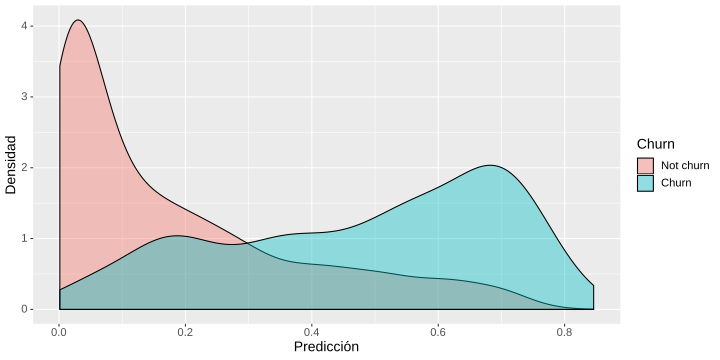

In [ ]:
prediction <- predict(logisticRegressionModel, newdata = testing, type = "response")

logisticRegressionModelPlots[["predictionAllFeatures"]] <- 
  ggplot(data.frame(prediction = prediction, Churn = testing$Churn), aes( prediction, fill = Churn ) ) + 
    geom_density(alpha = 0.4) +
    labs(x = "Predicción", y = "Densidad") +
    theme(text = element_text(size = 14))
options(repr.plot.width  = 10, repr.plot.height = 5)
logisticRegressionModelPlots$predictionAllFeatures

La siguiente figura muestra el valor que toman los estadísticos para cada valor del parámetro _cutoff_ comprendido en el rango [0.15, 0.85]:

Warning message in confusionMatrix.default(predicted, actual):
“Levels are not in the same order for reference and data. Refactoring data to match.”
Warning message:
“Removed 1 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_path).”


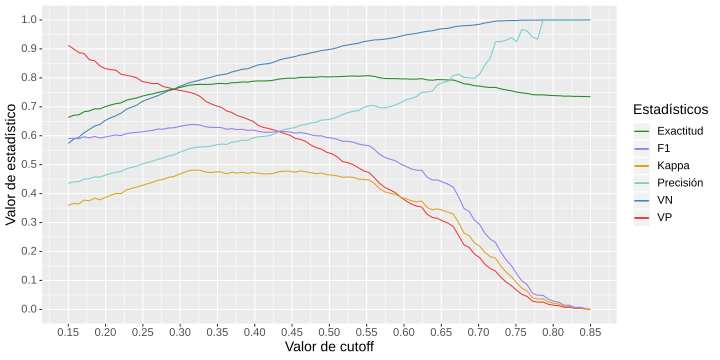

In [ ]:
result <- plotLogisticRegressionStatistics(prediction, actual)
logisticRegressionModelPlots[["statisticsAllFeatures"]] <- result$plot

options(repr.plot.width  = 10, repr.plot.height = 5)
logisticRegressionModelPlots$statisticsAllFeatures

A continuación se obtiene la curva ROC y se asocia un coste a los falsos positivos (3) y a los falsos negativos (1) con el objetivo de hallar el mejor valor de _cutoff_.

In [ ]:
ROCInfo <- getLogisticRegressionModelROCInfo(prediction, actual, FNCost, FPCost)

logisticRegressionModelPlots[["rocAllFeatures"]] <- ROCInfo$rocPlot
logisticRegressionModelPlots[["costAllFeatures"]] <- ROCInfo$costPlot

La gráfica que a continuación se presenta muestra la curva ROC para distintos valores del parámetro _cutoff_. El coste asociado se representa con el color de la línea de la curva. Los valores de la tasa de verdaderos positivos y falsos positivos que minimizan el coste se resaltan con dos rectas. Además, la siguiente celda de código imprime por pantalla el área bajo la curva ROC y los valores de las tasas de verdaderos positivos y negativos asociados al valor de _cutoff_ óptimo.

[1] "AUC:  0.842179445876288"

[1] "TP:  0.75"

[1] "TN:  0.788015463917526"

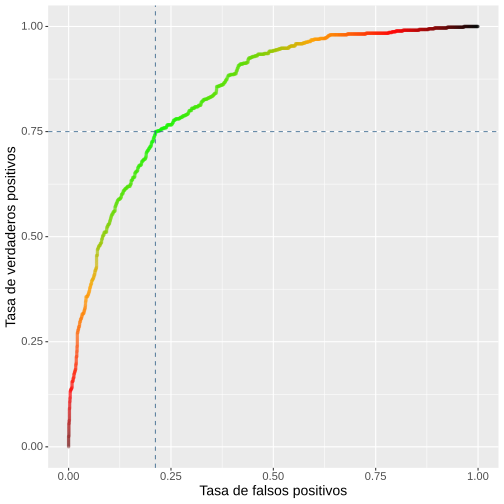

In [ ]:
paste("AUC: ", ROCInfo$auc)
paste("TP: ", ROCInfo$TP)
paste("TN: ", ROCInfo$TN)
options(repr.plot.width  = 7, repr.plot.height = 7)
ROCInfo$rocPlot

En la siguiente gráfica se muestra el coste asociado a cada valor de _cutoff_. También se imprime por pantalla el valor óptimo de _cutoff_ y el coste total asociado a dicho valor.

[1] "Cutoff:  0.31644396790016"

[1] "Total cost:  744.134020618557"

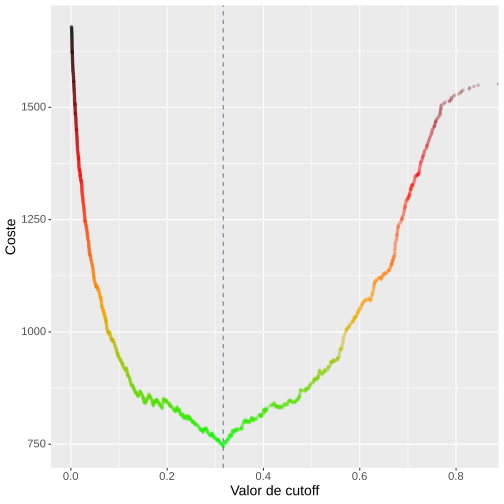

In [ ]:
paste("Cutoff: ", ROCInfo$cutoff)
paste("Total cost: ", ROCInfo$totalcost)
options(repr.plot.width  = 7, repr.plot.height = 7)
ROCInfo$costPlot

Una vez encontrado el mejor valor posible para el parámetro _cutoff_ (0.31 aproximadamente), conviene estudiar la matriz de confusión y los estadísticos de la predicción asociada a dicho valor de _cutoff_:

In [ ]:
conf <- getLogisticRegressionPredictionConfusionMatrix(prediction, ROCInfo$cutoff, actual)
conf
statistics <- getStatistics(conf)
statistics

Confusion Matrix and Statistics

           Reference
Prediction  Churn Not churn
  Churn       419       329
  Not churn   141      1223
                                         
               Accuracy : 0.7775         
                 95% CI : (0.7591, 0.795)
    No Information Rate : 0.7348         
    P-Value [Acc > NIR] : 3.559e-06      
                                         
                  Kappa : 0.4843         
                                         
 Mcnemar's Test P-Value : < 2.2e-16      
                                         
            Sensitivity : 0.7482         
            Specificity : 0.7880         
         Pos Pred Value : 0.5602         
         Neg Pred Value : 0.8966         
             Prevalence : 0.2652         
         Detection Rate : 0.1984         
   Detection Prevalence : 0.3542         
      Balanced Accuracy : 0.7681         
                                         
       'Positive' Class : Churn          
                      

$accuracy
[1] 0.7774621

$kappa
[1] 0.4842721

$TPRate
[1] 0.7482143

$TNRate
[1] 0.7880155

$precision
[1] 0.5601604

$f1
[1] 0.6406728

A continuación se genera la curva ROC a partir de las tasas de verdaderos y falsos positivos extraídas de la matriz de confusión obtenida al realizar la predicción sobre el conjunto de validación estableciendo el valor de _cutoff_ que minimiza el coste. Junto a la curva ROC es posible observar el valor del área bajo la misma.

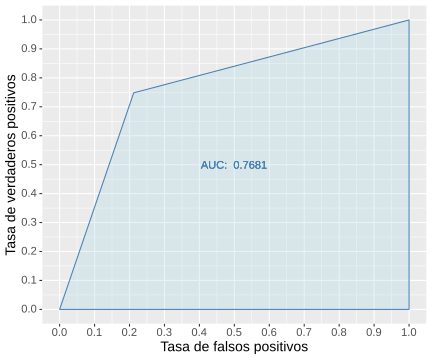

In [ ]:
roc <- plotROC(conf)

selectedCutoffROCPlot <- roc$plot

results$metrics$lrAllFeatures <- c(statistics, list(auc = roc$auc, totalCost = ROCInfo$totalcost))
results$predictions$lrAllFeatures <- factor(ifelse(prediction > ROCInfo$cutoff, "Churn", "Not churn"))

logisticRegressionModelPlots[["selectedCutoffROCAllFeatures"]] <- selectedCutoffROCPlot

options(repr.plot.width  = 6, repr.plot.height = 5)
selectedCutoffROCPlot

Por último, resulta interesante visualizar la representación gráfica de la matriz de confusión.

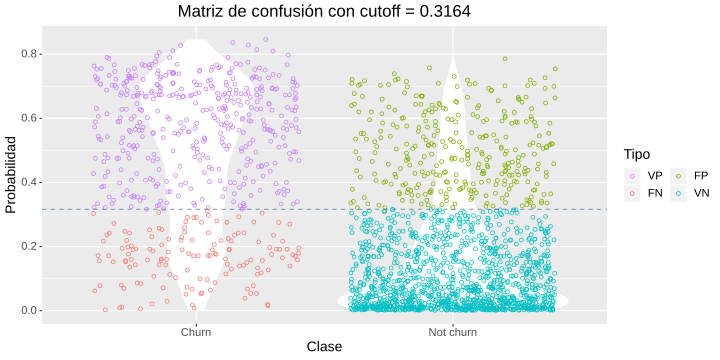

In [ ]:
cmInfo <- getLogisticRegressionModelConfusionMatrixInfo(prediction, ROCInfo$cutoff, actual)

logisticRegressionModelPlots[["cmAllFeatures"]] <- cmInfo$plot

options(repr.plot.width  = 10, repr.plot.height = 5)
logisticRegressionModelPlots$cmAllFeatures

Atendiendo a los coeficientes del modelo de regresión es posible crear una gráfica con el peso asociado a cada atributo:

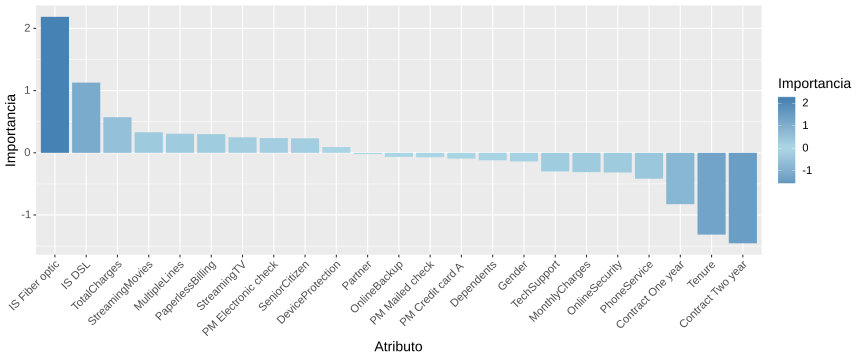

In [ ]:
featureImportancePlot <- plotLogisticRegressionModelFeatureImportance(logisticRegressionModel)

logisticRegressionModelPlots[["importanceAllFeatures"]] <- featureImportancePlot
options(repr.plot.width  = 12, repr.plot.height = 5)
logisticRegressionModelPlots$importanceAllFeatures

##### Selección de atributos

Conviene estudiar si es posible eliminar atributos para simplificar el modelo. Este estudio se realizará haciendo uso del *Criterio de información de Akaike (AIC)*.

In [ ]:
length(logisticRegressionModel$coefficients)

[1] 24

Hasta el momento, el modelo se ha construido con 24 características. Al ejecutar la siguiente celda comienza el proceso iterativo en dos direcciones de selección de características.

In [ ]:
logisticRegressionModel <- stepAIC(logisticRegressionModel, direction = "both", trace = TRUE)

Start:  AIC=4113.24
Churn ~ Gender + SeniorCitizen + Partner + Dependents + PhoneService + 
    MultipleLines + InternetService.xDSL + InternetService.xFiber.optic + 
    OnlineSecurity + OnlineBackup + DeviceProtection + TechSupport + 
    StreamingTV + StreamingMovies + Contract.xOne.year + Contract.xTwo.year + 
    PaperlessBilling + PaymentMethod.xCredit.card.A. + PaymentMethod.xElectronic.check + 
    PaymentMethod.xMailed.check + Tenure + MonthlyCharges + TotalCharges

                                  Df Deviance    AIC
- Partner                          1   4065.3 4111.3
- MonthlyCharges                   1   4065.3 4111.3
- OnlineBackup                     1   4065.3 4111.3
- DeviceProtection                 1   4065.4 4111.4
- PaymentMethod.xMailed.check      1   4065.5 4111.5
- PhoneService                     1   4065.5 4111.5
- StreamingTV                      1   4065.7 4111.7
- PaymentMethod.xCredit.card.A.    1   4065.7 4111.7
- StreamingMovies                  1   4066

Tras finalizar el proceso, las características eliminadas son:

- Partner
- MonthlyCharges
- PaymentMethod.xCredit.card.A.
- DeviceProtection
- PaymentMethod.xMailed.check
- Dependents
- OnlineBackup

In [ ]:
length(logisticRegressionModel$coefficients)
summary(logisticRegressionModel)

results$models$lrFeatureSelection <- logisticRegressionModel

[1] 17


Call:
glm(formula = Churn ~ Gender + SeniorCitizen + PhoneService + 
    MultipleLines + InternetService.xDSL + InternetService.xFiber.optic + 
    OnlineSecurity + TechSupport + StreamingTV + StreamingMovies + 
    Contract.xOne.year + Contract.xTwo.year + PaperlessBilling + 
    PaymentMethod.xElectronic.check + Tenure + TotalCharges, 
    family = binomial, data = training)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.8608  -0.6606  -0.2858   0.7381   3.3488  

Coefficients:
                                Estimate Std. Error z value Pr(>|z|)    
(Intercept)                     -1.98148    0.22470  -8.818  < 2e-16 ***
Gender                          -0.13839    0.07755  -1.784 0.074350 .  
SeniorCitizen                    0.25358    0.09822   2.582 0.009829 ** 
PhoneService                    -0.61848    0.15633  -3.956 7.62e-05 ***
MultipleLines                    0.25780    0.09515   2.709 0.006739 ** 
InternetService.xDSL             0.85608    0.16761 

A continuación se realiza la predicción sobre el conjunto de validación con el modelo simplificado y se estudian los resultados obtenidos:

[1] "AUC:  0.841055320323997"

[1] "TP:  0.757142857142857"

[1] "TN:  0.772551546391753"

[1] "Cutoff:  0.301630424579372"

[1] "Total cost:  759.027687776141"

Confusion Matrix and Statistics

           Reference
Prediction  Churn Not churn
  Churn       423       353
  Not churn   137      1199
                                          
               Accuracy : 0.768           
                 95% CI : (0.7494, 0.7858)
    No Information Rate : 0.7348          
    P-Value [Acc > NIR] : 0.0002597       
                                          
                  Kappa : 0.47            
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.7554          
            Specificity : 0.7726          
         Pos Pred Value : 0.5451          
         Neg Pred Value : 0.8975          
             Prevalence : 0.2652          
         Detection Rate : 0.2003          
   Detection Prevalence : 0.3674          
      Balanced Accuracy : 0.7640          
                                          
       'Positive' Class : Churn           
  

$accuracy
[1] 0.7679924

$kappa
[1] 0.4699751

$TPRate
[1] 0.7553571

$TNRate
[1] 0.7725515

$precision
[1] 0.5451031

$f1
[1] 0.6332335

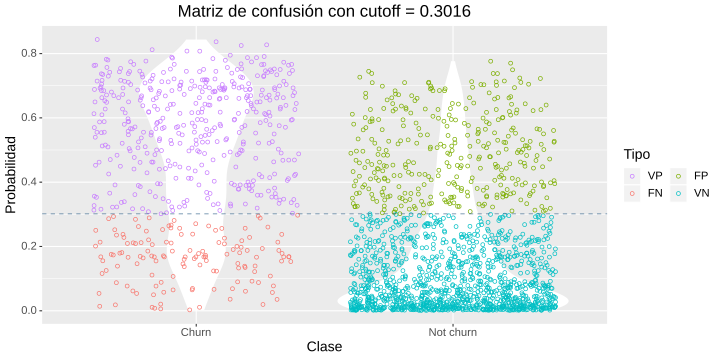

In [ ]:
prediction <- predict(logisticRegressionModel, newdata = testing, type = "response")
ROCInfo <- getLogisticRegressionModelROCInfo(prediction, actual, FNCost, FPCost)
paste("AUC: ", ROCInfo$auc)
paste("TP: ", ROCInfo$TP)
paste("TN: ", ROCInfo$TN)
paste("Cutoff: ", ROCInfo$cutoff)
paste("Total cost: ", ROCInfo$totalcost)

conf <- getLogisticRegressionPredictionConfusionMatrix(prediction, ROCInfo$cutoff, actual)
conf

statistics <- getStatistics(conf)
statistics

cmInfo <- getLogisticRegressionModelConfusionMatrixInfo(prediction, ROCInfo$cutoff, actual)
logisticRegressionModelPlots[["cmSelectedFeatures"]] <- cmInfo$plot

roc <- plotROC(conf)
logisticRegressionModelPlots[["selectedCutoffROCSelectedFeatures"]] <- roc$plot
options(repr.plot.width  = 10, repr.plot.height = 5)
logisticRegressionModelPlots$cmSelectedFeatures

En la siguiente celda de código se muestra la gráfica con el área bajo la curva ROC:

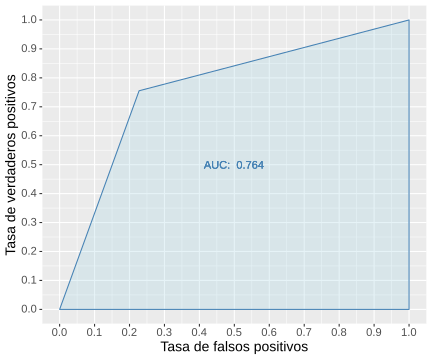

In [ ]:
options(repr.plot.width  = 6, repr.plot.height = 5)
logisticRegressionModelPlots$selectedCutoffROCSelectedFeatures

results$metrics$lrFeatureSelection <- c(statistics, list(auc = roc$auc, totalCost = ROCInfo$totalcost))
results$predictions$lrFeatureSelection <- factor(ifelse(prediction > ROCInfo$cutoff, "Churn", "Not churn"))

En la gráfica en la que se muestra la importancia de los atributos es posible apreciar cómo los atributos descartados se corresponden con aquellos con menos importancia (los situados hacia el centro de la gráfica del modelo previo), es decir, aquellos atributos cuyo coeficiente era cercano a 0.

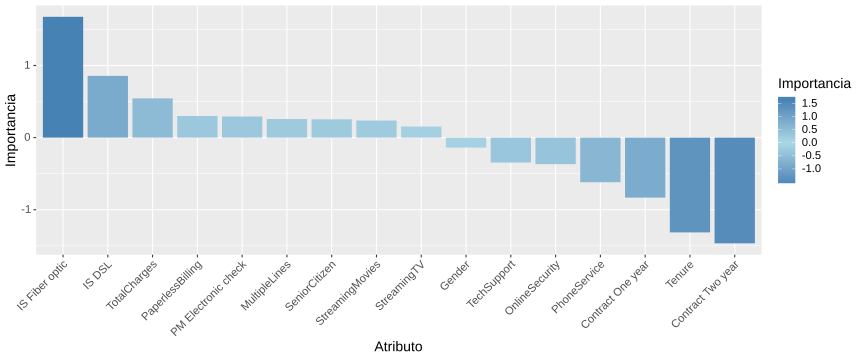

In [ ]:
featureImportancePlot <- plotLogisticRegressionModelFeatureImportance(logisticRegressionModel)

logisticRegressionModelPlots[["importanceSelectedFeatures"]] <- featureImportancePlot
options(repr.plot.width  = 12, repr.plot.height = 5)
logisticRegressionModelPlots$importanceSelectedFeatures

### Árbol de decisión

Se establece la semilla para la generación de números psudoaleatorios y se dividen las observaciones del conjunto de datos en dos grupos:

* Entrenamiento: 70% de las observaciones
* Validación: 30% restante de las observaciones

Los atributos que conforman el *dataframe* son los siguientes:

* Atributos categóricos simplificados
* Atributos numéricos


In [ ]:
decisionTreeDf <- df[ , setdiff(df %>% names, c("CustomerID", "CatTenure", "CatMonthlyCharges", "CatTotalCharges"))]
decisionTreeDf$Churn <- relevel(decisionTreeDf$Churn, ref = "Churn")

for (attributeName in simplifiedDf %>% names) {
  decisionTreeDf[[attributeName]] <- simplifiedDf[[attributeName]]
}

results$dataframes$dt <- decisionTreeDf
glimpse(decisionTreeDf)

set.seed(23)

trainPartition <- createDataPartition(decisionTreeDf$Churn, p = 0.7, list = FALSE)
training <- decisionTreeDf[trainPartition,]
testing <- decisionTreeDf[-trainPartition,]

Observations: 7,043
Variables: 20
$ Gender           <fct> Female, Male, Male, Male, Female, Female, Male, Fema…
$ SeniorCitizen    <fct> No, No, No, No, No, No, No, No, No, No, No, No, No, …
$ Partner          <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, Y…
$ Dependents       <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, N…
$ Tenure           <int> 1, 34, 2, 45, 2, 8, 22, 10, 28, 62, 13, 16, 58, 49, …
$ PhoneService     <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes, …
$ MultipleLines    <fct> No, No, No, No, No, Yes, Yes, No, Yes, No, No, No, Y…
$ InternetService  <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber …
$ OnlineSecurity   <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, No…
$ OnlineBackup     <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No, …
$ DeviceProtection <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No, …
$ TechSupport      <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No, No…
$ StreamingTV     

Creación del _environment_ en el que se almacenarán las gráficas generadas asociadas a los árboles de decisión:

In [ ]:
decisionTreePlots <- new.env()

#### Funciones auxiliares

In [ ]:
# Returns rpart decision tree feature importance plot
#
# @params tree rpart decision tree
# @return Feature importance plot
plotRpartDecisionTreeFeatureImportance <- function(tree) {
  featuresImportance <- data.frame(feature = tree$variable.importance %>% names, importance = (tree$variable.importance))
  
  return (ggplot(featuresImportance, aes(x = reorder(feature, -importance, sum), y = importance, fill = importance)) +
    geom_bar(stat = "identity") +
    labs(y = "Importancia",  x = "Atributo", fill = "Importancia") +
    scale_fill_gradient2(low = "steelblue", mid = "lightblue", high = "steelblue") +
    theme(
      axis.text.x = element_text(angle = 45, hjust = 1),
      text = element_text(size = 14)
    ))
}

#### Obtención del modelo

La siguiente celda de código lleva a cabo el entrenamiento del modelo con validación cruzada de 5 pliegues.

In [ ]:
tree <- rpart(
  Churn ~ ., 
  data = training, 
  method = "class",
  control = rpart.control(xval = 5),
)

results$models$dt <- tree

A continuación se muestra el árbol obtenido:

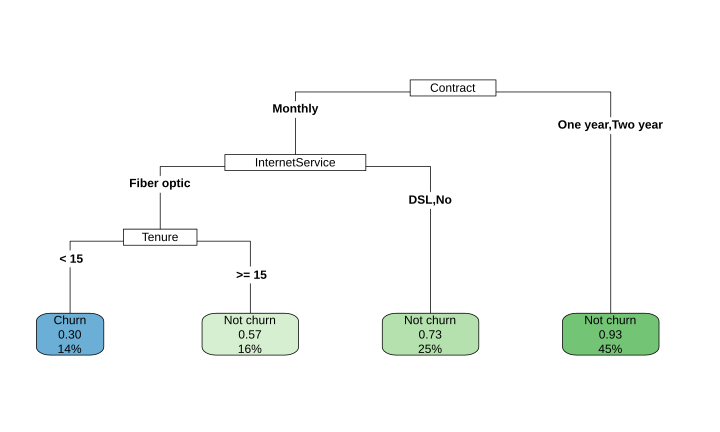

In [ ]:
decisionTreePlots[["dt"]] <- tree
options(repr.plot.width  = 10, repr.plot.height = 6)
rpart.plot(decisionTreePlots$dt, type = 5)

Gráfica con la importancia de las variables del árbol de decisión generado:

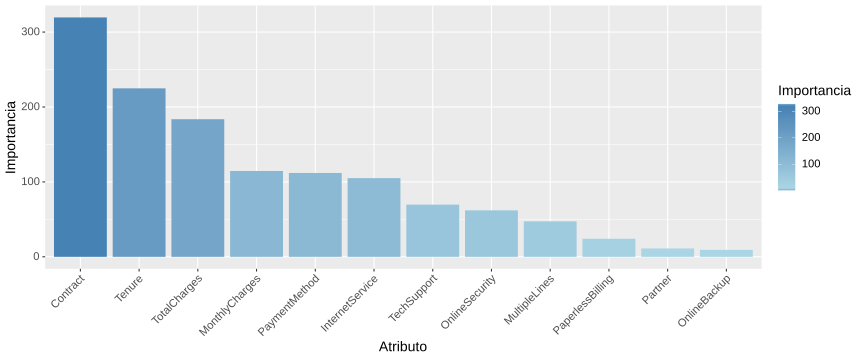

In [ ]:
decisionTreePlots[["dtImportance"]] <- plotRpartDecisionTreeFeatureImportance(tree)
options(repr.plot.width  = 12, repr.plot.height = 5)
decisionTreePlots$dtImportance

Predicción sobre el conjunto de validación, matriz de confusión y estadísticos. Atendiendo a la matriz de confusión y a los valores que toman los estadísticos _Precision_ y _Tasa de verdaderos positivos_ es posible apreciar que el problema de clases desbalanceadas del conjunto de datos está afectando negativamente al comportamiento del clasificador. La predicción que ha hecho a partir del conjunto de validación es de muy baja calidad.

In [ ]:
prediction <- predict(tree, newdata = testing, type = "class")
conf <- confusionMatrix(prediction, testing$Churn )
conf
statistics <- getStatistics(conf)
statistics

Confusion Matrix and Statistics

           Reference
Prediction  Churn Not churn
  Churn       204        91
  Not churn   356      1461
                                          
               Accuracy : 0.7884          
                 95% CI : (0.7703, 0.8056)
    No Information Rate : 0.7348          
    P-Value [Acc > NIR] : 6.94e-09        
                                          
                  Kappa : 0.3601          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.36429         
            Specificity : 0.94137         
         Pos Pred Value : 0.69153         
         Neg Pred Value : 0.80407         
             Prevalence : 0.26515         
         Detection Rate : 0.09659         
   Detection Prevalence : 0.13968         
      Balanced Accuracy : 0.65283         
                                          
       'Positive' Class : Churn           
  

$accuracy
[1] 0.7883523

$kappa
[1] 0.3601128

$TPRate
[1] 0.3642857

$TNRate
[1] 0.941366

$precision
[1] 0.6915254

$f1
[1] 0.477193

A continuación se muestra el coste total asociado a la predicción realizada:

In [ ]:
totalCost <-getTotalCost(conf, FNCost, FPCost)
paste("Total cost: ", totalCost)

[1] "Total cost:  1159"

En la gráfica que se genera al ejecutar la siguiente celda de código es posible visualizar el área bajo la curva del clasificador.

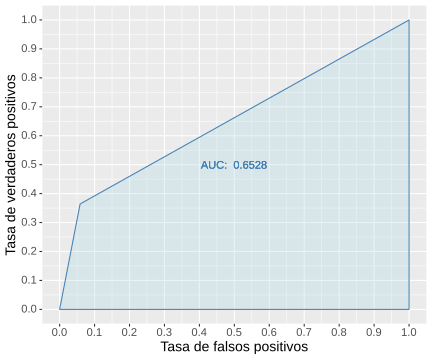

In [ ]:
roc <- plotROC(conf)
decisionTreePlots[["dtROC"]] <- roc$plot
options(repr.plot.width  = 6, repr.plot.height = 5)
decisionTreePlots$dtROC

results$metrics$dt <- c(statistics, list(auc = roc$auc, totalCost = totalCost))
results$predictions$dt <- prediction

##### Mitigación del problema de clases desbalanceadas

Al igual que en el caso del modelo de regresión logística, es posible establecer una matriz con los costes asociados a los falsos positivos y a los falsos negativos a la hora de construir el árbol de decisión. Se usarán los mismos valores que se utilizaron previamente:

* Falso positivo: coste de 1 unidad
* Falso negativo: coste de 3 unidades

In [ ]:
costMatrix <- matrix(c(0, FNCost, FPCost, 0), byrow = TRUE, nrow = 2)

tree <- rpart(
  Churn ~ ., 
  data = training, 
  method = "class",
  control = rpart.control(xval = 5), 
  parms = list(loss = costMatrix)
)

results$models$dtCostMatrix <- tree

A continuación se presenta el nuevo árbol de decisión obtenido:

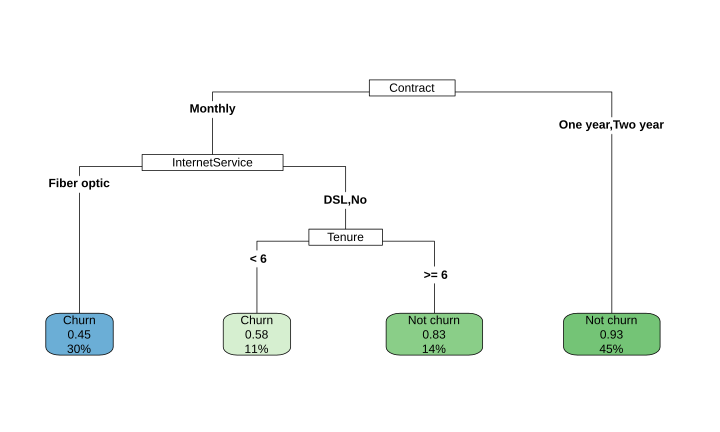

In [ ]:
decisionTreePlots[["dtCosts"]] <- tree
options(repr.plot.width  = 10, repr.plot.height = 6)
rpart.plot(decisionTreePlots$dtCosts, type = 5)

Gráfica con la importancia de las variables del nuevo árbol de decisión:

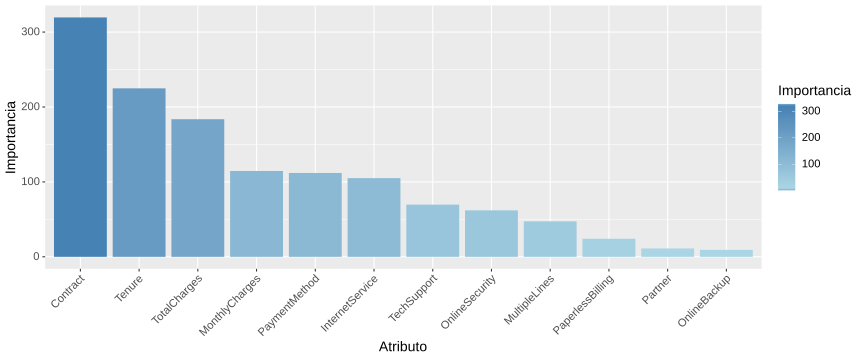

In [ ]:
decisionTreePlots[["dtImportanceCosts"]] <- plotRpartDecisionTreeFeatureImportance(tree)
options(repr.plot.width  = 12, repr.plot.height = 5)
decisionTreePlots$dtImportance

Predicción sobre el conjunto de validación, matriz de confusión y estadísticos. Cabe destacar que se ha conseguido una mejora significativa en relación al árbol de decisión obtenido sin la matriz de costes. Los valores de los estadísticos son más parecidos a los que se obtuvieron con los modelos de regresión lineal.

In [ ]:
prediction <- predict(tree, newdata = testing, type = "class")
conf <- confusionMatrix(prediction, testing$Churn )
conf
statistics <- getStatistics(conf)
statistics

Confusion Matrix and Statistics

           Reference
Prediction  Churn Not churn
  Churn       428       432
  Not churn   132      1120
                                          
               Accuracy : 0.733           
                 95% CI : (0.7135, 0.7517)
    No Information Rate : 0.7348          
    P-Value [Acc > NIR] : 0.5892          
                                          
                  Kappa : 0.4149          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.7643          
            Specificity : 0.7216          
         Pos Pred Value : 0.4977          
         Neg Pred Value : 0.8946          
             Prevalence : 0.2652          
         Detection Rate : 0.2027          
   Detection Prevalence : 0.4072          
      Balanced Accuracy : 0.7430          
                                          
       'Positive' Class : Churn           
  

$accuracy
[1] 0.7329545

$kappa
[1] 0.414901

$TPRate
[1] 0.7642857

$TNRate
[1] 0.7216495

$precision
[1] 0.4976744

$f1
[1] 0.6028169

El coste total asociado a la predicción realizada es de 828 unidades, muy inferior al obtenido previamente:

In [ ]:
totalCost <- getTotalCost(conf, FNCost, FPCost)

paste("Total cost: ", totalCost)

[1] "Total cost:  828"

El área bajo la curva del nuevo clasificador también ha aumentado de forma significativa:

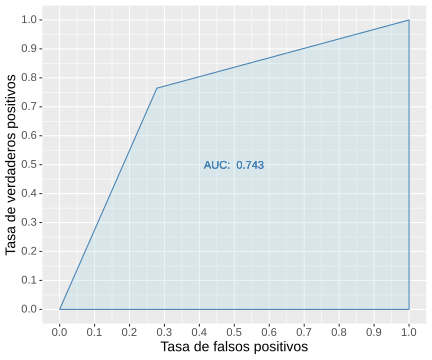

In [ ]:
roc <- plotROC(conf)
decisionTreePlots[["dtROCCosts"]] <- roc$plot
options(repr.plot.width  = 6, repr.plot.height = 5)
decisionTreePlots$dtROCCosts

results$metrics$dtCostMatrix <- c(statistics, list(auc = roc$auc, totalCost = totalCost))
results$predictions$dtCostMatrix <- prediction

### *Naïve* Bayes

Se establece la semilla para la generación de números psudoaleatorios y se dividen las observaciones del conjunto de datos en dos grupos:

* Entrenamiento: 70% de las observaciones
* Validación: 30% restante de las observaciones

Los atributos que conforman el *dataframe* para la construcción del clasificador _naïve_ Bayes son los siguientes:

* Atributos categóricos originales
* Atributos numéricos categorizados

In [ ]:
naiveBayesDf <- df[ , setdiff(df %>% names, c("CustomerID", "Tenure", "MonthlyCharges", "TotalCharges"))]
naiveBayesDf$Churn <- relevel(naiveBayesDf$Churn, ref = "Churn")

for (attributeName in simplifiedDf %>% names) {
  naiveBayesDf[[attributeName]] <- simplifiedDf[[attributeName]]
}

results$dataframes$nb <- naiveBayesDf
glimpse(naiveBayesDf)

set.seed(23)

trainPartition <- createDataPartition(naiveBayesDf$Churn, p = 0.7, list = FALSE)
training <- naiveBayesDf[trainPartition,]
testing <- naiveBayesDf[-trainPartition,]

Observations: 7,043
Variables: 20
$ Gender            <fct> Female, Male, Male, Male, Female, Female, Male, Fem…
$ SeniorCitizen     <fct> No, No, No, No, No, No, No, No, No, No, No, No, No,…
$ Partner           <fct> Yes, No, No, No, No, No, No, No, Yes, No, Yes, No, …
$ Dependents        <fct> No, No, No, No, No, No, Yes, No, No, Yes, Yes, No, …
$ PhoneService      <fct> No, Yes, Yes, No, Yes, Yes, Yes, No, Yes, Yes, Yes,…
$ MultipleLines     <fct> No, No, No, No, No, Yes, Yes, No, Yes, No, No, No, …
$ InternetService   <fct> DSL, DSL, DSL, DSL, Fiber optic, Fiber optic, Fiber…
$ OnlineSecurity    <fct> No, Yes, Yes, Yes, No, No, No, Yes, No, Yes, Yes, N…
$ OnlineBackup      <fct> Yes, No, Yes, No, No, No, Yes, No, No, Yes, No, No,…
$ DeviceProtection  <fct> No, Yes, No, Yes, No, Yes, No, No, Yes, No, No, No,…
$ TechSupport       <fct> No, No, No, Yes, No, No, No, No, Yes, No, No, No, N…
$ StreamingTV       <fct> No, No, No, No, No, Yes, Yes, No, Yes, No, No, No, …
$ StreamingMovies 

Creación del _environment_ en el que se almacenarán las gráficas generadas asociadas al clasificador _naïve_ Bayes:

In [ ]:
naiveBayesPlots <- new.env()

Entrenamiento del clasificador _naïve_ Bayes.

In [ ]:
actual <- relevel(testing$Churn, ref = "Churn")
nBayes <- naiveBayes(Churn ~ ., data = training)

results$models$nb <- nBayes

A continuación se lleva a cabo la predicción sobre el conjunto de validación y es posible observar la matriz de confusión y el valor de los estadísticos:

In [ ]:
prediction <- predict(nBayes, newdata = testing, type = "class")
conf <- confusionMatrix(prediction, testing$Churn )
conf
statistics <- getStatistics(conf)
statistics

Confusion Matrix and Statistics

           Reference
Prediction  Churn Not churn
  Churn       386       303
  Not churn   174      1249
                                          
               Accuracy : 0.7741          
                 95% CI : (0.7557, 0.7918)
    No Information Rate : 0.7348          
    P-Value [Acc > NIR] : 1.797e-05       
                                          
                  Kappa : 0.4602          
                                          
 Mcnemar's Test P-Value : 4.609e-09       
                                          
            Sensitivity : 0.6893          
            Specificity : 0.8048          
         Pos Pred Value : 0.5602          
         Neg Pred Value : 0.8777          
             Prevalence : 0.2652          
         Detection Rate : 0.1828          
   Detection Prevalence : 0.3262          
      Balanced Accuracy : 0.7470          
                                          
       'Positive' Class : Churn           
  

$accuracy
[1] 0.7741477

$kappa
[1] 0.4601759

$TPRate
[1] 0.6892857

$TNRate
[1] 0.804768

$precision
[1] 0.5602322

$f1
[1] 0.6180945

El coste total asociado a la predicción realizada es de 825 unidades:

In [ ]:
totalCost <- getTotalCost(conf, FNCost, FPCost)

paste("Total cost: ", totalCost)

[1] "Total cost:  825"

El área bajo la curva ROC alcanza un valor similar al de los obtenidos con los clasificadores previamente construidos:

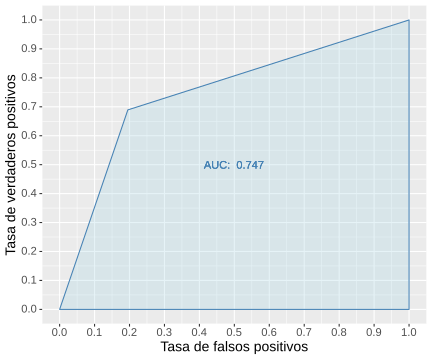

In [ ]:
roc <- plotROC(conf)

naiveBayesPlots[["nbROC"]] <- roc$plot

options(repr.plot.width  = 6, repr.plot.height = 5)
roc$plot

results$metrics$nb <- c(statistics, list(auc = roc$auc, totalCost = totalCost))
results$predictions$nb <- prediction

## Comparativa de los clasificadores obtenidos

En las siguientes celdas de código se crean las gráficas en las que se comparan los valores de las métricas estudiadas para comparar los clasificadores obtenidos:

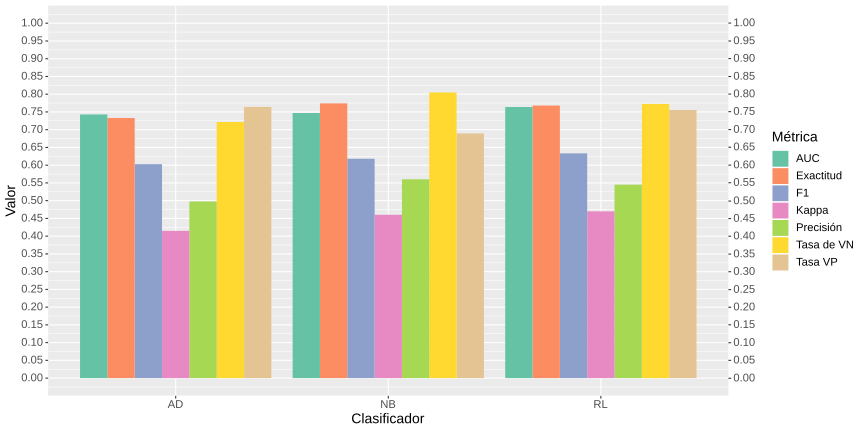

In [ ]:
classifier <- c(rep("RL" , 7) , rep("AD" , 7) , rep("NB" , 7))
metric <- rep(c("Exactitud" , "Tasa VP" , "Tasa de VN", "Precisión", "Kappa", "F1", "AUC") , 3)
value <- c(
  results$metrics$lrFeatureSelection[[1]],
  results$metrics$lrFeatureSelection[[3]],
  results$metrics$lrFeatureSelection[[4]],
  results$metrics$lrFeatureSelection[[5]],
  results$metrics$lrFeatureSelection[[2]],
  results$metrics$lrFeatureSelection[[6]],
  results$metrics$lrFeatureSelection[[7]],
  results$metrics$dtCostMatrix[[1]],
  results$metrics$dtCostMatrix[[3]],
  results$metrics$dtCostMatrix[[4]],
  results$metrics$dtCostMatrix[[5]],
  results$metrics$dtCostMatrix[[2]],
  results$metrics$dtCostMatrix[[6]],
  results$metrics$dtCostMatrix[[7]],
  results$metrics$nb[[1]],
  results$metrics$nb[[3]],
  results$metrics$nb[[4]],
  results$metrics$nb[[5]],
  results$metrics$nb[[2]],
  results$metrics$nb[[6]],
  results$metrics$nb[[7]]
)
data <- data.frame( classifier, metric, value)

options(repr.plot.width  = 12, repr.plot.height = 6)
comparisonPlot <- ggplot(data, aes(fill = metric, y = value, x = classifier)) + 
    geom_bar(position = "dodge", stat = "identity") +
    scale_fill_brewer(palette = "Set2") +
    labs(x = "Clasificador", y = "Valor", fill = "Métrica") +
    coord_cartesian(ylim = c(0, 1)) +
    scale_y_continuous(breaks = seq(0, 1, length = 21), sec.axis = sec_axis(~.*1, breaks = seq(0, 1, length = 21))) +
    theme(text = element_text(size = 14))

comparisonPlot

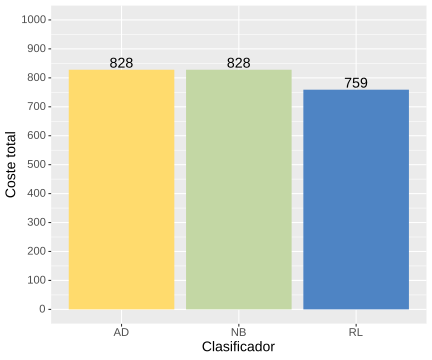

In [ ]:
classifier <- c("RL", "AD", "NB")
value <- c(results$metrics$lrFeatureSelection[[8]], results$metrics$dtCostMatrix[[8]], results$metrics$nb[[8]])
data <- data.frame( classifier, value)

options(repr.plot.width  = 6, repr.plot.height = 5)
totalCostComparisonPlot <- ggplot(data, aes(fill = classifier, y = value, x = classifier)) + 
    geom_bar(position = "dodge", stat = "identity") +
    scale_fill_manual(values = c("#FFDB6D", "#C3D7A4", "#4E84C4")) +
    labs(x = "Clasificador", y = "Coste total") +
    coord_cartesian(ylim = c(0, 1000))  +
    geom_text(aes(label = round(..y..)), vjust = -.2, size = 5) +
    theme(text = element_text(size = 14), legend.position = "none") +
    scale_y_continuous(breaks = seq(0, 1000, length = 11))

totalCostComparisonPlot

## Exportación de las figuras de la memoria

En las siguientes celdas se exportan las gráficas que han sido generadas a lo largo del *playbook*. Únicamente se exportan aquellas que se han incluido en el informe del proyecto. Cabe destacar que se exportan en formato _svg_.

In [ ]:
defaultHeight <- 6

oneColumnFigureHeight <- 5

### Análisis exploratorio

#### Atributo de clase

In [ ]:
svg(filename = "Churn.svg", height = defaultHeight)
barsPlots$Churn
dev.off()

svg(filename = "ChurnDonut.svg", height = defaultHeight)
donutPlots$Churn
dev.off()

png 
  2

png 
  2

#### Atributos con información sobre el cliente

In [ ]:
svg(filename = "SeniorCitizenBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$SeniorCitizen
dev.off()

svg(filename = "GenderBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$Gender
dev.off()

svg(filename = "PartnerBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$Partner
dev.off()

svg(filename = "DependentsBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$Dependents
dev.off()

svg(filename = "TenureDensity.svg", width = 12, height = oneColumnFigureHeight)
densityPlotsWithChurn$Tenure
dev.off()

svg(filename = "CatTenure.svg", width = 11, height = oneColumnFigureHeight)
barsPlotsWithChurn$CatTenure
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

#### Atributos con información sobre el contrato

In [ ]:
svg(filename = "Contract.svg", height = defaultHeight)
barsPlots$Contract
dev.off()

svg(filename = "ContractDonut.svg", height = defaultHeight)
donutPlots$Contract
dev.off()

svg(filename = "ContractBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$Contract
dev.off()

svg(filename = "PaymentMethodBarsPlot.svg", width = 12, height = defaultHeight)
barsPlotsWithChurn$PaymentMethod
dev.off()

svg(filename = "PaperlessBillingBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$PaperlessBilling
dev.off()

svg(filename = "MonthlyChargesDensity.svg", width = 12, height = oneColumnFigureHeight)
densityPlotsWithChurn$MonthlyCharges
dev.off()

svg(filename = "CatMonthlyCharges.svg", width = 10, height = oneColumnFigureHeight)
barsPlotsWithChurn$CatMonthlyCharges
dev.off()

svg(filename = "TotalChargesDensity.svg", width = 12, height = oneColumnFigureHeight)
densityPlotsWithChurn$TotalCharges
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

#### Atributos con información sobre los servicios que incluye el contrato

In [ ]:
svg(filename = "PhoneServiceBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$PhoneService
dev.off()

svg(filename = "MultipleLinesBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$MultipleLines
dev.off()

svg(filename = "InternetServiceBarsPlot.svg", height = defaultHeight)
barsPlotsWithChurn$InternetService
dev.off()

svg(filename = "InternetServiceDonut.svg", height = defaultHeight)
donutPlots$InternetService
dev.off()

svg(filename = "OnlineSecurityBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$OnlineSecurity
dev.off()

svg(filename = "OnlineBackupBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$OnlineBackup
dev.off()

svg(filename = "DeviceProtectionBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$DeviceProtection
dev.off()

svg(filename = "TechSupportBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$TechSupport
dev.off()

svg(filename = "StreamingTVBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$StreamingTV
dev.off()

svg(filename = "StreamingMoviesBarsPlot.svg", width = 7.5, height = defaultHeight)
barsPlotsWithChurn$StreamingMovies
dev.off()

svg(filename = "OnlineSecurityDonut.svg", height = defaultHeight)
donutPlots$OnlineSecurity
dev.off()

svg(filename = "TechSupportDonut.svg", height = defaultHeight)
donutPlots$TechSupport
dev.off()

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

### Clasificadores

#### Clasificador de regresión logística

In [ ]:
svg(filename = "lrmPredictionAllFeatures.svg", width = 10, height = oneColumnFigureHeight)
logisticRegressionModelPlots$predictionAllFeatures
dev.off()

svg(filename = "lrmStatisticsAllFeatures.svg", width = 10, height = oneColumnFigureHeight)
logisticRegressionModelPlots$statisticsAllFeatures
dev.off()

svg(filename = "lrmROCAllFeatures.svg", width = 6, height = defaultHeight)
ROCInfo$rocPlot
dev.off()

svg(filename = "lrmCostAllFeatures.svg", width = 6, height = defaultHeight)
ROCInfo$costPlot
dev.off()

svg(filename = "lrmSelectedCutoffROCAllFeatures.svg", width = 6, height = oneColumnFigureHeight)
logisticRegressionModelPlots$selectedCutoffROCAllFeatures
dev.off()

svg(filename = "lrmConfusionMatrixAllFeatures.svg", width = 10, height = oneColumnFigureHeight)
logisticRegressionModelPlots$cmAllFeatures
dev.off()

svg(filename = "lrmSelectedCutoffROCSelectedFeatures.svg", width = 6, height = oneColumnFigureHeight)
logisticRegressionModelPlots$selectedCutoffROCSelectedFeatures
dev.off()

svg(filename = "lrmConfusionMatrixSelectedFeatures.svg", width = 10, height = oneColumnFigureHeight)
logisticRegressionModelPlots$cmSelectedFeatures
dev.off()

svg(filename = "lrmImportanceAllFeatures.svg", width = 12, height = oneColumnFigureHeight)
logisticRegressionModelPlots$importanceAllFeatures
dev.off()

svg(filename = "lrmImportanceSelectedFeatures.svg", width = 12, height = oneColumnFigureHeight)
logisticRegressionModelPlots$importanceSelectedFeatures
dev.off()

png 
  2

Warning message:
“Removed 1 rows containing missing values (geom_path).”
Warning message:
“Removed 1 rows containing missing values (geom_path).”


png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

png 
  2

#### Árbol de decisión

In [ ]:
svg(filename = "dt.svg", width = 10, height = defaultHeight)
rpart.plot(decisionTreePlots$dt, type = 5)
dev.off()

svg(filename = "dtCosts.svg", width = 10, height = defaultHeight)
rpart.plot(decisionTreePlots$dtCosts, type = 5)
dev.off()

svg(filename = "dtROC.svg", width = 6, height = oneColumnFigureHeight)
decisionTreePlots$dtROC
dev.off()

svg(filename = "dtROCCosts.svg", width = 6, height = oneColumnFigureHeight)
decisionTreePlots$dtROCCosts
dev.off()

Warning message:
“Cannot retrieve the data used to build the model (model.frame: object 'Tenure' not found).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


png 
  2

Warning message:
“Cannot retrieve the data used to build the model (model.frame: object 'Tenure' not found).
To silence this warning:
    Call rpart.plot with roundint=FALSE,
    or rebuild the rpart model with model=TRUE.”


png 
  2

png 
  2

png 
  2

#### Clasificador _naïve_ Bayes

In [ ]:
svg(filename = "nbROC.svg", width = 6, height = oneColumnFigureHeight)
naiveBayesPlots$nbROC
dev.off()

png 
  2

### Comparativa de los modelos

In [ ]:
svg(filename = "comparison.svg", width = 12, height = defaultHeight)
comparisonPlot
dev.off()

svg(filename = "comparisonTotalCost.svg", width = 6, height = oneColumnFigureHeight)
totalCostComparisonPlot
dev.off()

png 
  2

png 
  2